# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

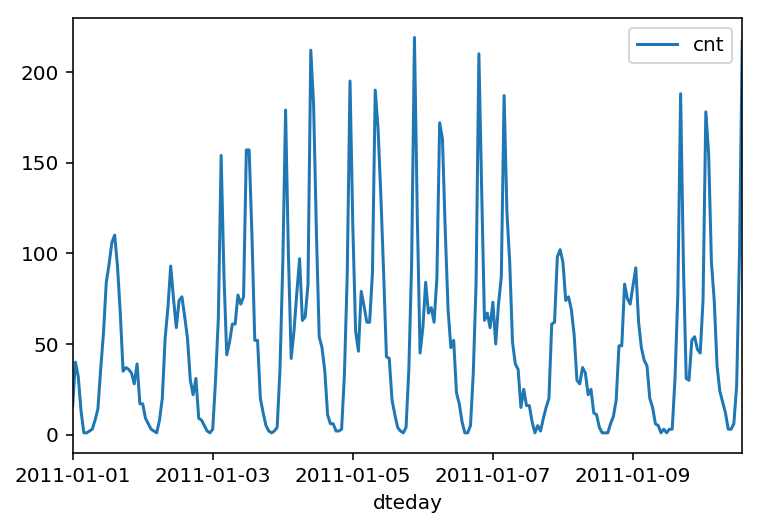

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [9]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        # self.activation_function = lambda x : 0  # Replace 0 with your sigmoid calculation.
        
        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your 
        # implementation there instead.
        #
        #def sigmoid(x):
        #    return 0  # Replace 0 with your sigmoid calculation here
        #self.activation_function = sigmoid
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))  # Replace 0 with your sigmoid calculation here
        self.activation_function = sigmoid
                    
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        print(targets)
        for X, y in zip(features, targets):
            #### Implement the forward pass here ####
            ### Forward pass ###
            # TODO: Hidden layer - Replace these values with your calculations.
            hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

            # TODO: Output layer - Replace these values with your calculations.
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
            final_outputs = final_inputs
            
            #self.activation_function(final_inputs) # signals from final output layer
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # TODO: Output error - Replace this value with your calculations.
            error = y - final_outputs # Output layer error is the difference between desired target and actual output.
            
            # TODO: Calculate the hidden layer's contribution to the error
            # hidden_error = np.dot(output_error_term, self.weights_hidden_to_output)
            
            # TODO: Backpropagated error terms - Replace these values with your calculations.
            output_error_term = error * 1.0 #error * final_outputs * (targets - final_outputs)
            # hidden_error_term = None
            
            #hidden_error = error - hidden_outputs
            hidden_error = np.dot(self.weights_hidden_to_output, error)
            hidden_error_term = hidden_error * hidden_outputs * (1- hidden_outputs)
        
            #np.dot(output_error_term, self.weights_hidden_to_output) * hidden_outputs * (1 - hidden_outputs)

            # Weight step (input to hidden)
            delta_weights_i_h += hidden_error_term * X[:, None]
            # Weight step (hidden to output)
            delta_weights_h_o += output_error_term * hidden_outputs[:, None]

        # TODO: Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output += self.lr * delta_weights_h_o #/ n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h #/ n_records # update input-to-hidden weights with gradient descent step
 
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        # hidden_inputs = np.dot(self.input_nodes, self.weights_input_to_hidden) # signals into hidden layer
        hidden_inputs =  np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs

In [10]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [11]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....

[[ 0.4]]



----------------------------------------------------------------------
Ran 5 tests in 0.005s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, if you use too many iterations, then the model with not generalize well to other data, this is called overfitting. You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. As you start overfitting, you'll see the training loss continue to decrease while the validation loss starts to increase.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [138]:
import sys

### Set the hyperparameters here ###
iterations = 300
learning_rate = 0.01
hidden_nodes = 9
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

11403    2.561018
461     -0.895668
6748     0.432978
10525    1.078006
11231   -1.005929
10843   -0.669633
14335    2.175104
13060    0.455031
1164    -0.939773
12943    0.477083
846      0.146299
2581    -0.460137
2167    -1.033495
11595    2.412166
14801    0.339256
3500     0.328230
12347    2.605122
10355    0.173865
7226     2.004199
1194    -0.393980
8851    -0.664120
5676    -0.631041
8995     0.085656
8736    -0.366415
8297    -0.493215
11400   -0.912207
14461    3.658116
15180    2.880775
1843    -0.460137
239      0.151813
           ...   
4188    -0.178971
6806    -0.978364
5533    -0.019092
6444    -0.675146
10153   -0.901181
14251   -0.741303
12316    0.785814
8654    -0.823998
8624    -0.945286
11976   -0.978364
10566    0.570805
8061    -0.862590
4936    -0.228588
15339    0.091169
11527    0.195917
5008    -0.366415
10601    1.293015
14641   -0.272693
11874   -0.631041
2787    -0.719250
2073    -0.890155
1591    -0.393980
11479    1.055954
4162     1.419815
10610   -0

Progress: 2.0% ... Training loss: 0.955 ... Validation loss: 1.2589138    -0.393980
6261    -0.928746
972     -0.978364
14553    1.778164
4290     1.149676
1828    -0.614502
7272     0.262074
6928     0.240021
5084     1.838808
8939     1.265450
13736    0.543240
8590     0.278613
8145    -0.702711
11305   -0.873616
2592    -0.912207
10397    2.605122
230     -0.835024
11912    0.885049
3454     0.036038
8236    -0.079736
5922    -0.449111
7287    -0.917720
8653    -0.967338
13473    0.217969
11809   -0.862590
6120     0.592857
1711    -0.895668
14096    0.576318
10442   -0.868103
1747     0.030525
           ...   
12589    3.057193
10528    1.982147
5353    -0.559372
8190    -0.653094
12486    2.092408
9977    -0.311284
11175    0.559779
10240    1.954582
451     -0.349876
4220     2.197156
15043   -0.691685
8509    -0.939773
12086    1.028388
1322    -0.261667
12140   -0.592450
5162    -0.879129
1743     0.499135
5440     0.168352
11509    1.640338
15354   -0.057684
10594    0.59837

Progress: 4.3% ... Training loss: 0.766 ... Validation loss: 1.31310683   -0.399493
11209   -0.250641
7242    -0.140379
1607    -0.388467
1424    -0.460137
7043    -1.027981
6429     0.151813
10863    1.678929
8507    -1.022468
2565     0.741710
1956    -0.967338
8376     0.267587
1489    -0.724763
2546    -0.801946
15423    0.940180
9829     0.361309
6148     0.548753
6914     1.678929
14052    3.465159
9764     0.377848
5326     0.019499
8344     1.144163
8415    -0.019092
2842     1.485972
9954     0.240021
744     -0.757842
14665   -0.857077
286     -0.278206
14733   -1.011442
8531    -1.000416
           ...   
1496     0.240021
12468    3.327333
13240   -0.548346
4216    -0.008066
11481    1.381224
11008    0.118734
2516     1.276476
2577    -0.052171
10966   -0.846051
421     -0.631041
8168    -0.934260
14875   -0.796433
7120    -1.005929
5238    -1.016955
11022   -0.063197
4529    -0.228588
4956     0.394387
265     -0.741303
8557     0.151813
3048    -0.239614
20      -0.84605

Name: cnt, dtype: float64
Progress: 6.7% ... Training loss: 0.687 ... Validation loss: 1.2223421    -0.129353
8385    -0.983877
11037   -0.994903
14913   -0.256154
3939    -0.520780
13463   -0.994903
6734    -1.005929
9619     0.934666
2664    -0.460137
14306    1.298528
4777    -0.476676
13375    0.262074
11643    0.041551
13069    2.412166
12847    2.020739
14197    1.033902
2875     1.215832
5264    -0.625528
5003    -0.129353
5529     0.851971
4234     2.015225
14317    3.013089
11760   -0.912207
204     -0.818485
10898   -0.349876
13272   -0.801946
13933    3.707734
9532    -1.033495
3805     0.978771
78      -0.812972
           ...   
1964    -0.256154
11525   -0.178971
4648     1.326093
11584    0.273100
8271     0.228995
5180     1.871886
11542   -1.027981
6196     1.667903
2989    -0.355389
1890    -0.487702
12472    0.824405
4259     0.388874
2918     0.311691
6096     0.195917
11599    0.614909
2505    -0.008066
547     -0.912207
1399    -0.614502
11732   -0.967338
13817   

Progress: 9.0% ... Training loss: 0.646 ... Validation loss: 1.16111553    0.080143
13178   -0.757842
11509    1.640338
12934   -1.005929
1891    -0.586937
11326   -0.823998
12618   -0.096275
12539    1.309554
2916    -0.344363
7599    -0.653094
8599    -0.978364
6824    -0.327823
15093   -0.950799
10880    0.780301
3681     0.796840
7896     0.201430
8865    -0.608989
651     -0.719250
10772   -0.526293
93      -1.011442
11415    1.050441
11350   -1.039008
12171   -0.212049
14190    0.455031
4655     0.096682
7096     0.085656
9846    -0.989390
662     -0.928746
2847     0.025012
1629    -0.371928
           ...   
15010    3.090271
4449    -0.653094
11181   -0.967338
7185    -0.928746
7934    -0.564885
5802    -1.011442
9843    -0.934260
14137   -0.178971
12006    2.158565
12479   -1.000416
6646     1.463920
7916    -0.228588
1528    -1.022468
12952    1.149676
12410    1.971121
13084    0.570805
12288   -0.796433
2207    -0.267180
622     -1.027981
6766    -0.631041
1450    -0.14037

Progress: 11.3% ... Training loss: 0.607 ... Validation loss: 1.09313737    0.388874
14691   -0.107301
421     -0.631041
14778   -0.344363
1397    -0.647581
464     -0.129353
8599    -0.978364
5199    -0.079736
3380     1.805729
5829    -0.487702
11205   -1.022468
8337    -0.983877
3007    -0.884642
11434    0.080143
12220    0.372335
2319    -0.278206
9834    -0.178971
7585     0.030525
2629     0.703118
4135    -0.978364
9699    -1.027981
10263    2.246774
3830     0.036038
11738    1.259937
3380     1.805729
13496    0.907101
5362     1.386737
4238     0.240021
11805   -0.735789
15218    1.618285
           ...   
1883    -0.818485
12804    2.516914
5204     2.180617
4649     0.741710
13838    1.144163
4038    -0.983877
721     -0.708224
377     -1.039008
1223    -1.005929
12895    0.653501
6504    -0.382954
4911    -0.206536
12356   -0.967338
7813    -1.022468
650     -0.691685
11808   -0.972851
15253    2.742949
1082    -0.278206
10195   -0.382954
9857     0.350283
5644     1.5411

Progress: 13.7% ... Training loss: 0.559 ... Validation loss: 0.9521259    -0.741303
7156    -0.201023
4188    -0.178971
6438     0.223482
8964    -0.597963
12299    0.179378
14113   -0.134866
8043     0.240021
1927    -0.906694
9269    -1.000416
5142    -1.011442
3693     1.293015
27      -1.011442
11378    1.105571
1204    -0.846051
2481    -0.118327
8253    -0.140379
1527    -0.994903
2709     0.388874
3432    -0.267180
3729     0.686579
2304    -0.520780
3979     1.144163
6559     0.063604
8498    -0.956312
7698    -0.223075
8874    -0.294745
12662    1.496998
15202    2.533453
11260    0.614909
           ...   
10858    0.432978
4270     0.438491
13520    2.406652
9993    -0.008066
9623    -0.421545
3387    -0.956312
10490   -1.011442
6183    -0.923233
12982   -0.917720
6835     0.091169
11001    1.618285
12210   -0.592450
12241   -0.250641
7162    -0.972851
2118    -0.983877
4777    -0.476676
10758    0.725170
6449    -0.846051
1583    -0.597963
14303   -1.000416
7697     0.0029

Progress: 16.0% ... Training loss: 0.540 ... Validation loss: 0.959596     -1.027981
9348    -0.575911
11295    0.835431
5303    -0.123840
6319    -0.289232
14712   -0.823998
5102     0.146299
11015   -1.027981
8629    -0.774381
98      -0.559372
9639     0.295152
14893    3.222585
7332    -1.027981
8663    -0.460137
13637    0.228995
7103    -0.024605
10168   -0.030118
251     -0.868103
13154   -0.653094
13012    0.162839
12268    0.670040
12420    2.946932
5609     0.328230
9045     0.653501
6124     0.769275
2509    -0.647581
11253   -1.011442
2424    -0.603476
5941    -0.691685
15117   -0.956312
           ...   
15203    2.527940
5710     0.300665
5264    -0.625528
2879    -0.217562
324     -0.890155
7160    -0.840538
10828   -0.581424
9735    -0.305771
15171    0.118734
6879    -0.873616
14125    3.542342
13982    1.667903
986     -0.520780
12358   -1.016955
2426    -0.807459
8918    -0.388467
14985    1.226858
1107    -0.647581
14409    0.339256
10169   -0.316797
7860    -1.0114

Progress: 18.3% ... Training loss: 0.470 ... Validation loss: 0.820799     -0.586937
8250    -0.443598
13247   -1.005929
7518     0.129760
14157   -0.807459
10556   -0.548346
13248   -0.818485
8398    -0.763355
1361    -1.000416
464     -0.129353
10331    1.717520
11872   -0.206536
7978    -0.702711
13091    1.100058
14652    3.211559
11657    0.151813
12958   -1.000416
973     -1.033495
10395   -0.377441
12104    0.620422
9366    -1.039008
2475    -0.939773
1224    -1.022468
2540     1.386737
6108    -0.608989
3804     0.670040
10103   -0.934260
3207    -0.371928
2812    -0.851564
10829   -0.355389
           ...   
12462    0.410926
8287    -0.631041
2316    -0.515267
7503    -0.416032
2942     1.011849
6266    -0.735789
10251   -0.884642
6669     0.730683
10355    0.173865
6590    -1.016955
4926    -1.011442
6179    -0.967338
7184    -0.757842
2354    -0.961825
10463   -0.812972
1496     0.240021
14215    0.510161
12378   -0.570398
563     -0.405006
5051     0.030525
4224    -0.0356

Progress: 20.7% ... Training loss: 0.425 ... Validation loss: 0.7381564    -0.967338
2653    -0.234101
3677    -1.033495
15085    3.487211
3359    -0.002553
12314   -0.570398
6586    -0.675146
5914    -0.901181
12283   -0.570398
6848    -0.471163
3929     0.295152
744     -0.757842
8694    -1.027981
2591    -0.890155
8851    -0.664120
13288    1.011849
5356    -1.022468
2410     0.609396
1150    -0.239614
7245    -0.057684
12839   -0.972851
13112    0.664527
1354     0.289639
13914   -0.283719
14019   -0.388467
266     -0.774381
4007     0.091169
6655    -0.090762
7396     0.631448
2762    -0.460137
           ...   
12002   -0.548346
6482     0.091169
6143     1.028388
5739     0.047064
5576    -0.482189
13534   -1.033495
9456    -0.388467
9103    -0.939773
4558     0.840945
3670     0.807866
11364    0.234508
15165   -0.537319
6094     0.339256
7022    -0.912207
10368   -1.033495
6356    -0.371928
11533    2.616149
11659   -0.305771
4483     0.956719
8737    -0.548346
13699   -0.7247

Progress: 23.0% ... Training loss: 0.410 ... Validation loss: 0.65314490   -0.085249
817     -0.085249
14386    0.510161
2928    -0.212049
1116    -1.011442
11866    0.036038
8933    -0.967338
1673     0.510161
5317     0.047064
11208   -0.879129
10627    0.449518
8715    -0.945286
2468     0.482596
8148    -1.016955
10673    0.383361
10889    0.295152
4711    -0.917720
2607     0.675553
2920     0.129760
1924    -0.829511
2628     0.548753
6012    -1.033495
3606    -0.961825
10381    0.967745
12072   -0.851564
8495    -0.570398
8615    -0.041144
5019    -0.978364
7675    -0.300258
4167    -0.140379
           ...   
1196    -0.592450
3985    -0.537319
8513    -0.542833
11603    0.995310
6710    -1.005929
7571    -1.016955
10870   -1.016955
4164    -0.217562
15117   -0.956312
11982    2.186130
12956   -0.812972
13342   -0.730276
10679   -0.934260
794     -0.647581
12169   -0.923233
14750    2.241261
13536   -0.763355
1779    -0.449111
8646    -0.531806
14367    0.118734
14636   -0.8846

Progress: 25.3% ... Training loss: 0.393 ... Validation loss: 0.6168306    -0.178971
11114    0.587344
12104    0.620422
6920    -0.548346
8236    -0.079736
13400    0.173865
5387     0.107708
14183   -0.901181
9305     1.215832
15266    1.794703
14939    1.524563
4257     0.295152
7644    -0.840538
10837    1.772651
8936    -0.928746
1539    -0.504241
12212   -0.967338
1622    -0.917720
304     -1.039008
3925    -0.046657
12421    3.266689
14770    0.708631
13846   -0.818485
12442    0.791327
14496   -0.923233
10496    0.984284
9540    -0.333336
1571    -0.857077
8650    -1.016955
12481   -0.603476
           ...   
8537    -0.879129
9816    -0.636554
371     -0.945286
14477    0.366822
10637   -0.195510
8994     0.091169
5347     1.877399
10392   -1.022468
7736    -0.763355
4017     0.659014
6014    -1.000416
9029    -0.978364
10982    1.805729
12680    2.340496
5372     2.097921
14725    4.292118
6465    -0.686172
8680     0.069117
9589    -0.173458
13957    3.426568
15365   -0.0246

Name: cnt, dtype: float64
Progress: 27.7% ... Training loss: 0.350 ... Validation loss: 0.572752     -0.234101
11303   -0.994903
12918    0.107708
9191    -0.382954
10502    1.938043
15006    2.406652
4316    -0.046657
1384    -0.923233
4521     0.774788
7506     0.240021
5452    -0.664120
12388    0.802353
3335    -0.008066
7907    -1.005929
9346     1.673416
7498    -0.983877
6190    -0.713737
8083    -0.460137
13987   -0.052171
618     -0.890155
14862    2.037278
9663    -0.432571
5023    -0.928746
9479    -0.614502
9503    -0.680659
4825    -0.768868
5966    -0.796433
8737    -0.548346
584     -0.807459
2233    -0.597963
           ...   
5452    -0.664120
4557     1.265450
12043   -0.846051
4881     0.868510
8883    -0.890155
3042     0.548753
7471    -0.393980
13219   -0.664120
12706    0.262074
10877    1.204806
12148    0.548753
7104     0.140786
11864   -0.074223
10574    2.974497
3946    -0.322310
9380     1.723034
1225    -1.033495
3497     0.670040
13051   -0.752329
13349  

Progress: 30.0% ... Training loss: 0.321 ... Validation loss: 0.5503354     0.482596
2370    -0.261667
14823    1.182754
13715    1.298528
456     -1.011442
2604    -0.333336
11905   -0.173458
7843    -0.393980
12127    0.725170
89      -0.779894
8099    -1.011442
9858     0.289639
13525    1.794703
14413    3.465159
7341    -0.057684
7717    -1.016955
9719    -0.620015
7180     0.267587
9146    -0.757842
11469   -0.730276
15430   -1.011442
11146    2.583070
12993    1.210319
4094     0.063604
1461    -1.027981
1532    -1.000416
6624     1.519050
7939    -0.162432
10683   -0.399493
10883    0.697605
           ...   
9701    -1.033495
562     -0.581424
958     -0.300258
14090    1.667903
6983     1.204806
1205    -0.515267
2860    -1.022468
7892    -0.162432
6096     0.195917
8279    -0.201023
4507     1.789190
7654     0.989797
3604    -0.719250
14829   -0.531806
12112    0.526700
11578    0.366822
4684    -0.972851
9394     1.822269
3458    -0.586937
5689     0.262074
6288     1.1055

Progress: 32.3% ... Training loss: 0.403 ... Validation loss: 0.55411275   -0.691685
7687    -0.614502
4091     0.228995
7184    -0.757842
4651     0.989797
10354    0.333743
1284    -0.101788
280     -1.027981
12646   -0.895668
2432    -0.989390
9038    -0.570398
15088    0.592857
2246    -0.504241
13678   -0.741303
7265     1.133137
6037    -1.000416
13751   -1.022468
1125    -0.101788
4279    -0.967338
1144    -0.156919
10398    0.890562
5474    -0.636554
14511    0.096682
10849   -0.912207
14893    3.222585
14735   -0.994903
6468    -0.879129
11593   -0.294745
12840   -1.000416
315     -0.669633
           ...   
14801    0.339256
2987    -0.063197
14166    1.910477
12836   -0.344363
5676    -0.631041
15095   -0.967338
858     -1.033495
14884    0.603883
7453    -1.005929
3388    -0.967338
5712    -0.101788
14721    0.829918
10062   -0.405006
9164    -0.377441
14055    1.337120
2496    -0.548346
2371     0.659014
12011    2.136513
7831    -0.680659
64      -0.438084
1628    -0.8019

Progress: 34.7% ... Training loss: 0.321 ... Validation loss: 0.5218360    -0.928746
3376    -0.118327
6056    -0.162432
7617    -0.752329
1817    -0.608989
11944    0.603883
12660    2.224722
1155    -0.785407
2733     1.182754
1993    -0.823998
14943    1.210319
13441   -0.206536
5911    -0.553859
9398    -0.057684
4710    -1.022468
13772   -0.812972
4604     1.689955
9947     0.212456
4178    -0.879129
13513   -0.939773
6972    -0.790920
5283    -0.620015
14760   -0.779894
800     -0.581424
1362    -1.022468
5883    -0.724763
498     -0.796433
5465     1.105571
14883    2.720897
14742    0.317204
           ...   
2088    -0.531806
13018    0.857484
5919    -1.027981
5421    -0.267180
9348    -0.575911
3       -0.972851
2971     0.890562
14526    1.651364
8442    -0.471163
7763    -0.989390
1882    -0.994903
41      -0.752329
11384    0.190404
1204    -0.846051
9901    -0.068710
6302    -1.000416
12602    1.745086
11137   -0.928746
13858    1.436355
2786    -0.515267
5425    -0.4160

Progress: 37.0% ... Training loss: 0.321 ... Validation loss: 0.5373188     1.601746
15092   -0.884642
1872    -0.167945
14264    0.697605
3431    -0.212049
5354    -0.873616
2801     0.421952
7492    -0.178971
14711   -1.016955
2897    -0.234101
5427    -0.934260
4719    -0.382954
12796    0.791327
14711   -1.016955
2357    -1.033495
10602    1.017362
272     -0.586937
10090    0.168352
10800   -0.873616
14706   -0.537319
11430   -0.212049
3033     0.708631
11694    0.129760
3404     1.590720
13658   -0.625528
10565    1.904964
9719    -0.620015
15033    2.627175
13144    0.609396
12097   -0.184484
           ...   
3408    -0.052171
13655   -0.983877
1988     0.344770
9889    -1.011442
8630    -0.548346
14234    1.816755
5322     0.565292
8855     0.002960
7266     0.355796
11869    0.609396
8803     1.430842
7951    -0.520780
3294    -0.978364
7053     0.025012
1809    -1.011442
13832    1.860860
185     -0.906694
3332     1.452894
4699     1.783677
14462    2.318444
2088    -0.5318

Progress: 39.3% ... Training loss: 0.511 ... Validation loss: 0.662170     -0.934260
3751    -0.890155
8984    -1.016955
14540   -0.741303
2214    -1.027981
9948    -0.035631
14105    0.201430
13868   -0.983877
10580   -0.355389
13525    1.794703
2148    -0.173458
5747    -0.057684
5641     0.642475
3989    -1.039008
11004    1.579694
4492    -0.978364
4117     0.780301
12164   -0.614502
6542    -1.016955
5948     0.096682
14784   -0.730276
14385    0.311691
10616    0.708631
3968    -0.862590
1909     0.262074
13948    0.901588
969     -0.829511
6484    -0.085249
11      -0.735789
11222    1.915990
           ...   
533     -0.482189
10685    2.577557
2481    -0.118327
7476    -0.890155
8615    -0.041144
12033   -0.052171
14830   -0.840538
14408    0.543240
6015    -0.934260
12795    2.334983
12080    0.444005
3790     0.471570
3762     0.526700
15224    0.636961
13202    0.223482
12255    1.331607
2915    -0.008066
13486   -0.906694
3276     0.736196
4025    -0.107301
6144     0.6700

Progress: 41.7% ... Training loss: 0.329 ... Validation loss: 0.55014432    0.609396
11700    3.195019
8703    -0.631041
3791     0.168352
8662    -0.432571
7321     0.868510
6350    -1.000416
9098    -0.895668
13238    1.237885
10007   -0.884642
13840    0.548753
2630     1.094545
6688    -0.366415
5576    -0.482189
11381   -0.151406
6778    -0.460137
3190     0.515674
1025    -0.757842
15367    1.116597
981     -0.195510
4605     1.127623
2341    -0.774381
12854    1.287502
2616    -0.112814
5350     0.526700
11882   -0.537319
9409    -0.509754
8526    -0.978364
5657    -1.027981
9947     0.212456
           ...   
6734    -1.005929
3286     0.322717
9095    -0.377441
5746    -0.068710
6780    -0.735789
4668    -0.327823
6188    -0.879129
14251   -0.741303
10324   -0.950799
14927   -0.989390
11534    1.552129
5016    -0.289232
4466    -0.195510
9400     0.013986
11274   -0.250641
2212    -0.972851
9371     0.394387
11560    0.510161
6915     1.541103
197     -0.586937
12762   -0.3664

Progress: 44.0% ... Training loss: 0.305 ... Validation loss: 0.49810660   -0.829511
7285    -1.000416
12160    0.339256
1407    -0.752329
5109     1.006336
11807   -0.994903
11984    2.836671
5379    -0.967338
11116    0.774788
12375    1.496998
14168    2.505887
5460     0.642475
13069    2.412166
11021    0.532213
9050    -0.950799
5876     0.763762
10546    0.521187
8780     0.576318
12817   -0.785407
5970    -0.840538
3528    -0.167945
8137    -0.024605
1213    -0.647581
4740    -0.614502
9785     0.647988
979     -0.427058
971     -0.934260
10625    1.408789
1493    -0.620015
4461     0.642475
           ...   
4062    -1.005929
3803    -0.041144
10455    1.204806
1517    -0.647581
6903    -0.537319
8416     0.846458
7274     1.601746
4602     0.945693
478     -0.895668
8254    -0.316797
6348    -0.983877
5757     1.469433
3386    -0.796433
6195     1.772651
5997    -0.134866
9165    -0.553859
11246    0.984284
13990   -0.928746
2866    -0.608989
11391    0.526700
9476    -0.6916

Progress: 46.3% ... Training loss: 0.308 ... Validation loss: 0.5124785    -0.796433
12952    1.149676
3604    -0.719250
7902    -0.564885
716     -1.027981
10146   -0.223075
1458    -0.829511
15035    2.765001
13701   -1.000416
4053     0.840945
141     -1.039008
5859    -0.553859
11752   -0.857077
3865    -0.438084
2473    -0.735789
8764    -0.906694
4266     1.309554
1235    -0.664120
14785    0.030525
8732    -0.322310
4718    -0.223075
7023    -0.504241
6753    -0.785407
12068   -0.868103
1489    -0.724763
11931    2.450757
4037    -1.005929
1291    -0.857077
10433    0.774788
3677    -1.033495
           ...   
5590     0.195917
3282     1.552129
2486    -0.030118
11165    1.276476
2014     0.002960
7592    -0.724763
359     -0.531806
4049    -0.239614
2118    -0.983877
13453    3.239124
6450    -0.675146
532     -0.068710
9502    -0.768868
6983     1.204806
2086    -0.294745
4211     0.173865
11353   -0.796433
3765     0.642475
3231    -0.035631
14273    0.504648
1113    -1.0059

Progress: 48.7% ... Training loss: 0.350 ... Validation loss: 0.4794310     1.182754
10065   -0.989390
9926     0.151813
14136   -0.846051
6164    -0.465650
3084    -0.327823
5673     0.482596
7892    -0.162432
9713     0.421952
2909    -0.994903
13199   -1.033495
4983     0.576318
10196   -0.614502
9481    -0.658607
9294    -1.000416
7007     0.091169
12082    0.372335
11859   -0.184484
2528    -0.691685
11168    2.709871
9137    -0.388467
12626    1.326093
12287   -1.011442
11611   -0.553859
5207     0.223482
5531     0.195917
2217    -0.691685
14450    1.888425
5265     0.410926
3068     1.860860
           ...   
2421     0.107708
5179     1.860860
539     -0.730276
14640   -0.823998
14724    3.757351
1041    -1.039008
5996    -0.333336
8069    -1.011442
7856    -0.923233
3493     0.725170
4621     1.138650
3202     1.452894
14879   -0.983877
5145    -0.829511
6655    -0.090762
13682   -0.823998
6050     0.482596
12205    1.066980
5164    -1.005929
9029    -0.978364
4929     0.3557

Progress: 51.0% ... Training loss: 0.272 ... Validation loss: 0.4533377    -0.041144
5522    -0.851564
9465    -0.890155
9760    -0.752329
2162    -0.779894
12579    2.886288
13301    0.432978
1461    -1.027981
4293     0.636961
2888    -0.553859
14219    1.491485
11860   -0.438084
3921     0.333743
1335    -0.625528
6753    -0.785407
8137    -0.024605
15180    2.880775
12884   -0.879129
6835     0.091169
12757    2.660253
5570    -0.757842
4962     0.620422
12855    0.785814
6572    -0.333336
4883     0.146299
3095    -0.195510
125     -0.719250
5719     2.070356
9623    -0.421545
1768    -0.625528
           ...   
12994    1.182754
94      -1.033495
15273    0.339256
460     -1.016955
11840    2.274339
10069   -0.548346
14343    0.284126
11351   -1.027981
14782   -0.983877
2485    -0.366415
6147     0.747223
10668    1.276476
459     -1.039008
4799    -0.195510
4009    -0.713737
10902   -0.123840
9960    -0.790920
10829   -0.355389
13833    1.557642
12997    0.824405
13930    0.4881

Progress: 53.3% ... Training loss: 0.308 ... Validation loss: 0.4727461     0.973258
7611     0.763762
12564    2.709871
7927    -0.642068
12840   -1.000416
1855    -1.005929
855     -1.033495
2314     0.686579
7067    -1.000416
11968    0.377848
14692    0.603883
3870    -1.022468
4279    -0.967338
10684    0.995310
14387    1.403276
2224    -0.300258
41      -0.752329
1935    -0.355389
8847    -0.559372
1429    -0.564885
5553     0.653501
241     -0.746816
5843    -0.691685
7648    -0.917720
5517     1.248911
2697     0.311691
8756     0.041551
385     -0.531806
1274    -1.005929
13947    2.803592
           ...   
1332    -0.603476
14487    0.918127
13899    2.842184
7082     0.730683
453     -0.735789
10276   -0.575911
7502    -0.939773
3128    -0.950799
2854     0.554266
7513     0.692092
10882    0.670040
3687     0.036038
5319     1.033902
11501    1.050441
3822    -1.022468
7791    -0.989390
12923    1.116597
9372    -0.250641
536     -0.697198
908     -0.371928
3390    -1.0334

Progress: 55.7% ... Training loss: 0.275 ... Validation loss: 0.4698278    -0.338849
7024     0.686579
7930    -0.989390
10170   -0.559372
13907    1.408789
6374    -1.022468
5893    -1.022468
509     -0.939773
12084    0.526700
11508    1.833295
80      -0.614502
8933    -0.967338
195     -0.774381
7591    -0.581424
10850   -0.438084
1366    -1.016955
7858    -1.016955
6155    -0.989390
1673     0.510161
3890    -0.785407
368     -0.730276
3363    -1.000416
6108    -0.608989
11109   -0.983877
14714    1.419815
11207   -0.994903
10181    0.388874
5597    -0.983877
2465     1.094545
11824    0.223482
           ...   
364     -0.498728
7035     1.811242
1433    -0.939773
405     -0.818485
13376    0.273100
7340    -0.338849
769     -0.570398
7145    -0.603476
2815    -0.934260
1293    -0.840538
8668    -0.884642
6239     0.019499
9251     0.466057
2310    -1.039008
7343    -0.245127
9336    -0.691685
7002     0.030525
6575     0.008473
15359   -0.983877
6341     1.066980
11274   -0.2506

Progress: 58.0% ... Training loss: 0.525 ... Validation loss: 0.6228899    -0.393980
10744    1.469433
5968    -0.829511
2074    -0.520780
5388    -0.393980
12510    1.706494
14821    3.410029
4678     0.736196
5210    -0.840538
1664    -0.785407
13684    0.201430
5765     1.055954
13432    0.714144
13167    0.477083
6343    -0.041144
1784    -0.912207
4684    -0.972851
5688    -0.079736
7730    -0.145892
3628    -0.691685
8468    -0.526293
5012     1.949069
15154    1.116597
6691     0.251048
3172    -1.000416
12431   -1.011442
3539     0.096682
2856    -0.421545
3313    -0.686172
10226   -1.027981
           ...   
11091    2.395626
9119    -0.471163
6492    -1.022468
5060     1.667903
3090     0.609396
6298    -0.090762
10466   -1.000416
12953    0.466057
3295    -1.011442
5996    -0.333336
7694    -0.945286
2947     0.907101
7053     0.025012
3892    -1.016955
3901    -0.217562
4828    -1.011442
186     -0.978364
611     -0.223075
149     -0.719250
7409     1.359172
12768   -0.8239

Progress: 60.3% ... Training loss: 0.302 ... Validation loss: 0.5044440    -0.112814
2997     1.072493
7698    -0.223075
7694    -0.945286
14091    2.715384
6472    -0.961825
8560    -0.432571
14288    0.862997
5463     1.039415
8998    -0.438084
9525     0.063604
13796   -0.807459
12706    0.262074
9612    -0.201023
13611    2.974497
3749    -1.011442
6639    -0.961825
5261    -0.994903
12107    1.105571
9941    -0.592450
2628     0.548753
8536    -0.713737
13562    1.800216
2486    -0.030118
8570    -0.658607
7131    -0.807459
13886    2.483835
5065    -0.735789
10381    0.967745
577     -0.647581
           ...   
13490   -0.840538
7664    -0.890155
10405    0.918127
12311   -0.972851
15400   -0.212049
12640    0.791327
1359    -0.785407
10942   -0.983877
6168    -0.008066
12803    1.050441
15065   -0.096275
9397    -0.256154
5859    -0.553859
8594    -0.669633
12716   -0.967338
7584    -0.405006
13271   -1.016955
11888    0.273100
4863    -0.041144
4294     0.521187
1826    -0.3719

Progress: 62.7% ... Training loss: 0.267 ... Validation loss: 0.45412700    0.333743
5218     1.155189
9299    -0.173458
15213   -0.978364
10987   -0.393980
13350    1.441868
9016     0.212456
1548    -0.702711
3673    -0.713737
11767    0.455031
10326   -0.548346
14797    3.652603
8642    -0.757842
1135    -0.956312
3483    -0.608989
13219   -0.664120
4962     0.620422
7635     0.102195
1684    -0.206536
15294    0.135273
7122    -0.934260
9985    -0.812972
7683     0.013986
2646    -1.016955
6524    -0.349876
7868    -0.945286
4370    -0.840538
1925    -0.890155
4566    -1.011442
1301    -0.476676
           ...   
9920     0.289639
6643    -0.024605
5773    -0.564885
3176    -0.774381
11011   -0.763355
13514   -0.835024
11819    2.213696
11477    0.559779
7923     0.212456
4962     0.620422
3316    -1.016955
6244     1.993173
4480     0.879536
5988    -0.978364
6221     0.515674
15127    0.802353
10652   -0.465650
5457    -0.801946
3162     0.201430
12686    1.105571
11529    0.1573

Progress: 65.0% ... Training loss: 0.267 ... Validation loss: 0.452881     -1.005929
14000    2.092408
11170    2.357035
11403    2.561018
14299   -0.432571
15421    3.277715
2626    -0.603476
13125   -0.950799
2907    -0.868103
1495    -0.371928
9477    -0.603476
252     -0.934260
14821    3.410029
12485    1.524563
748     -0.785407
1445    -0.123840
15093   -0.950799
3818    -0.890155
3702    -1.011442
14249    0.234508
324     -0.890155
10256   -0.283719
9982    -0.542833
14206   -1.027981
5166    -0.989390
10849   -0.912207
8109    -0.118327
9987    -1.011442
8193    -1.022468
5658    -0.950799
           ...   
1892    -0.548346
6305    -0.835024
7414    -0.515267
9650    -0.912207
14169    2.252287
15147    2.842184
6361     0.085656
14624    0.008473
13106    0.846458
3464    -0.961825
3701    -1.027981
11192    0.405413
6909     0.052578
3039     0.019499
8320    -0.868103
1878    -1.027981
12044   -0.895668
6630     0.069117
14450    1.888425
11580    2.974497
10454    0.3778

Progress: 67.3% ... Training loss: 0.276 ... Validation loss: 0.4391880    -1.039008
10377    0.300665
5719     2.070356
13022    1.061467
13594    0.703118
13846   -0.818485
13365   -0.961825
7237    -1.022468
2633     0.989797
4722     0.245534
12201    1.519050
5245    -0.013579
6951    -0.945286
10507   -0.493215
3636     0.339256
1739    -1.016955
13865   -0.178971
2183    -0.542833
14858   -0.653094
13212    3.636064
14826    0.030525
5941    -0.691685
2700    -0.537319
5492     0.670040
8937    -0.642068
4729    -0.498728
11240   -0.691685
15249   -0.145892
7114    -0.945286
2313    -0.074223
           ...   
9854     0.405413
15344    2.869749
9317    -0.928746
11183   -1.011442
15058    0.609396
1229     0.344770
13852    0.217969
14236    0.763762
4662    -1.022468
3281     1.745086
1190    -0.664120
12888   -0.829511
8992     0.190404
15105    0.482596
13746   -0.234101
425     -0.156919
8400    -0.487702
3200    -0.487702
3070     0.477083
3955     1.430842
6148     0.5487

Progress: 69.7% ... Training loss: 0.269 ... Validation loss: 0.4287236    -1.016955
12600   -0.823998
3787     0.813379
12283   -0.570398
6453    -0.316797
3133     0.730683
13128   -0.851564
12576   -0.823998
12465    1.011849
3416    -0.597963
6496    -0.526293
1092    -0.768868
9197    -1.027981
8823     0.366822
11732   -0.967338
6251    -0.873616
11629    2.489348
7331    -1.033495
10504    0.896075
3829    -0.167945
9734    -0.107301
106     -0.702711
15129    0.377848
3988    -1.033495
10614    1.050441
14978    1.728547
5435     0.157326
13770   -0.206536
2224    -0.300258
1101    -0.096275
           ...   
3087     0.201430
3609    -0.564885
2284    -0.840538
15066   -0.526293
10512   -1.033495
12277    3.283228
14817    1.000823
14136   -0.846051
4422    -0.983877
6403     0.195917
10598    3.421055
11277   -0.928746
5030    -0.178971
13998    1.706494
9369     0.493622
12999    0.565292
8652    -1.005929
1       -0.823998
9575    -0.504241
9548     0.818892
4352    -0.5262

Progress: 72.0% ... Training loss: 0.269 ... Validation loss: 0.42711922   -0.311284
4344     0.752736
11850   -0.636554
9523     1.364685
285      0.069117
1253    -0.416032
6553    -0.041144
3323    -0.123840
5027     0.129760
5267     0.085656
9201     0.234508
7271     0.063604
7692    -1.027981
14564   -0.912207
11324   -0.642068
3989    -1.039008
6524    -0.349876
687     -0.950799
5816     0.763762
7470    -0.371928
15258   -0.504241
5388    -0.393980
2350    -0.476676
7892    -0.162432
1317    -1.039008
4048    -0.245127
5764     0.862997
14714    1.419815
289     -0.757842
15031    3.233611
           ...   
11636   -0.454624
9520    -0.101788
913     -0.779894
2715    -0.934260
14735   -0.994903
9483    -0.763355
8019     0.653501
7752    -0.223075
8557     0.151813
7603    -0.410519
13528    0.857484
284     -0.647581
7905    -0.989390
2616    -0.112814
10444    0.488109
5500    -1.000416
5948     0.096682
12582    0.311691
2908    -0.956312
6911    -0.189997
9725    -1.0390

Progress: 74.3% ... Training loss: 0.302 ... Validation loss: 0.44414880   -0.796433
10789    0.978771
1115    -1.027981
13327    1.706494
11390    1.612772
13161    0.653501
12064    0.394387
2215    -1.039008
1413    -1.039008
9951    -0.063197
12836   -0.344363
3346     1.348146
11386    0.256561
4445    -0.879129
4580     2.142026
12557   -0.355389
1125    -0.101788
11538   -0.713737
2695    -0.950799
8076    -1.033495
13040    0.256561
7334    -0.901181
9970     0.113221
785     -1.000416
14214    0.284126
5343     0.019499
5239    -0.906694
5944    -1.000416
1106    -0.360902
1153    -0.812972
           ...   
2855     0.195917
10668    1.276476
3495     0.885049
2486    -0.030118
8029    -0.934260
11018   -0.432571
12125    0.234508
3130    -0.658607
13838    1.144163
13225   -0.013579
3037    -0.267180
14267    1.491485
1974    -1.016955
4213    -0.107301
774      0.085656
9611    -0.360902
3899     0.394387
5150     0.995310
12591    1.425328
9272    -0.647581
8538    -0.9122

Progress: 76.7% ... Training loss: 0.270 ... Validation loss: 0.42712538    0.383361
11799    0.835431
4179    -0.972851
10224   -1.022468
3685    -0.212049
13341   -0.410519
15065   -0.096275
4843     1.629312
1734    -0.564885
8730    -0.631041
6805    -0.812972
6888    -0.382954
11614   -0.967338
13563    3.051680
6074     0.179378
5306    -0.548346
11958    0.796840
12688    0.311691
14148    3.316307
5125     0.879536
12680    2.340496
9964    -1.027981
5338     0.912614
2049    -0.846051
7716    -1.027981
9752     0.543240
1725    -0.432571
5366    -0.151406
6335    -0.013579
1243    -0.741303
           ...   
5477    -0.763355
4610    -0.438084
8171    -1.033495
13128   -0.851564
2500    -0.972851
1269    -0.895668
11714    1.508024
5859    -0.553859
9829     0.361309
13391   -1.005929
8153    -0.454624
2813    -0.956312
10446    0.675553
1336    -0.796433
4648     1.326093
3487    -1.005929
12917   -0.096275
9348    -0.575911
6978    -0.256154
2483    -0.112814
9563    -0.4491

Progress: 79.0% ... Training loss: 0.254 ... Validation loss: 0.4209821    -1.027981
8157     0.432978
14642    1.634825
10829   -0.355389
3396    -0.256154
10483    0.118734
6996    -1.022468
10434    0.295152
3712    -0.189997
13572    3.746325
10627    0.449518
873     -0.735789
1086    -0.868103
14771    1.761625
12734    1.789190
6932    -0.085249
4240    -0.145892
9727    -0.520780
12679    2.346009
7186    -0.983877
10442   -0.868103
920     -0.647581
4668    -0.327823
7472    -0.487702
491     -0.581424
11875   -0.868103
1949    -0.873616
300     -0.961825
4040    -0.371928
2217    -0.691685
           ...   
10028    0.030525
6935     0.047064
13096    2.175104
574     -1.039008
8636     0.350283
3787     0.813379
11150    1.485972
10994   -0.890155
4789     0.146299
2923     2.004199
11868    0.217969
142     -1.016955
4938     0.240021
10866   -0.366415
3370     1.882912
2970     1.078006
4542    -1.016955
5670     2.213696
930     -0.272693
9366    -1.039008
10176   -1.0224

Name: cnt, dtype: float64
Progress: 81.3% ... Training loss: 0.258 ... Validation loss: 0.44914753    0.146299
9966    -0.917720
138     -0.950799
13690    1.717520
8638    -0.333336
4989     0.466057
10813    1.904964
7957    -1.011442
9225     0.372335
5637    -1.000416
7637    -0.145892
8051    -1.027981
15070   -1.016955
9464    -1.016955
10402    0.355796
3245    -1.016955
511     -0.724763
9842    -0.961825
14806   -0.967338
318     -0.278206
14185   -0.934260
2021    -1.022468
555      0.267587
2983    -0.917720
15267    3.415542
3550     0.366822
4183    -0.928746
11619    2.362548
2994     0.631448
452     -0.730276
           ...   
8373    -0.046657
6422    -1.000416
4430     0.129760
1853    -0.868103
12478   -0.823998
837      0.223482
4080    -0.151406
6560    -0.195510
4713     0.625935
8364    -1.022468
2113    -0.741303
10330    1.513537
11487   -0.482189
3446     0.929153
4824    -0.504241
15233    0.096682
5132     0.118734
13315    0.008473
11998   -0.680659
3476   

Progress: 83.7% ... Training loss: 0.260 ... Validation loss: 0.43212133    1.833295
11100    2.572044
882     -0.807459
5537     2.268826
913     -0.779894
9891    -1.033495
10566    0.570805
14441    0.251048
7875     0.333743
15157    2.632688
9290    -0.664120
11530    0.228995
2755     1.756112
8269    -0.901181
11953   -0.041144
1453    -0.658607
4117     0.780301
3917    -1.011442
13057   -0.195510
5004    -0.509754
2849    -0.195510
1462    -1.033495
11294    1.667903
11278   -0.989390
13892   -0.945286
10931    0.438491
1455    -0.697198
2284    -0.840538
14091    2.715384
4239     0.234508
           ...   
10963   -0.421545
48      -1.033495
5917    -1.000416
11528    0.317204
11359   -0.333336
5389    -0.338849
9520    -0.101788
1248    -1.033495
611     -0.223075
5192    -0.487702
7143    -0.989390
4566    -1.011442
6395    -0.917720
9388    -1.005929
8022    -0.460137
11959    0.940180
2874     0.030525
10747   -0.096275
629     -0.614502
7515     1.651364
11887    0.4109

Progress: 86.0% ... Training loss: 0.255 ... Validation loss: 0.41711437    2.616149
11997   -0.504241
10902   -0.123840
8000    -0.912207
6529     0.025012
480     -0.978364
13711    0.488109
7643    -0.735789
6371    -0.967338
5601     0.421952
2389    -0.410519
4013    -1.033495
11619    2.362548
10203   -0.906694
7352    -0.779894
13483   -0.476676
7402    -0.983877
930     -0.272693
15333   -0.631041
4439     0.080143
14036   -0.967338
1503    -0.989390
3236     1.783677
9006    -1.027981
4204    -0.956312
3845    -1.033495
12964    0.609396
9797    -1.005929
14006    0.471570
11773    3.200533
           ...   
7480    -0.807459
1883    -0.818485
2006    -0.597963
5007    -0.217562
8662    -0.432571
10456    0.587344
15111    1.348146
7559    -0.708224
8383    -0.752329
13686    1.761625
3218    -0.884642
3902     0.091169
13596    3.988900
80      -0.614502
2834    -0.956312
13777   -0.035631
7462     0.901588
11112   -0.928746
9940    -0.901181
10389   -0.829511
2610     1.3040

Progress: 88.3% ... Training loss: 0.301 ... Validation loss: 0.4359935    -0.790920
9302     0.686579
4503    -0.267180
775     -0.189997
7216     0.339256
12554    0.625935
6575     0.008473
13613    0.179378
217     -0.008066
10601    1.293015
3466    -0.515267
4154    -0.868103
1189    -0.724763
11388    2.765001
7045    -1.016955
2413    -0.294745
5759    -0.272693
15002   -0.620015
1024    -0.438084
10959    1.226858
14813    0.311691
2254    -0.752329
2145    -0.790920
8813    -0.647581
4889    -0.272693
11477    0.559779
9019    -0.052171
1113    -1.005929
3348    -0.449111
14701    2.042791
           ...   
12234   -0.768868
10361    0.532213
6324    -1.000416
4234     2.015225
8373    -0.046657
3285     0.614909
6343    -0.041144
10112   -0.316797
2764    -0.686172
5242     1.105571
15253    2.742949
13457   -0.669633
9025    -0.807459
13796   -0.807459
8432    -0.994903
13704   -0.785407
9738     1.640338
6214     0.019499
11274   -0.250641
5153     0.752736
7544    -0.6034

Progress: 90.7% ... Training loss: 0.296 ... Validation loss: 0.4474008    -0.327823
755     -0.746816
2252    -0.228588
8636     0.350283
129     -0.702711
8083    -0.460137
7051    -0.322310
9616     0.008473
7339    -0.366415
1452    -0.553859
5879    -0.989390
10811    1.993173
965     -0.823998
9530    -0.967338
13089    1.971121
8796    -0.691685
11870    0.631448
4385    -0.024605
2352    -0.746816
13092    1.237885
13736    0.543240
390     -0.537319
12033   -0.052171
5672     0.978771
542     -0.201023
5618    -0.245127
9240    -0.421545
11750   -0.504241
14355   -0.311284
14648    0.907101
           ...   
1495    -0.371928
1740    -0.989390
12588    3.680168
4322    -0.272693
12759    1.199293
13584   -0.719250
2941     0.868510
5700    -0.531806
14147    1.645851
11777    0.234508
3336    -0.322310
14339    1.348146
3022     0.559779
7351    -0.449111
7047    -0.537319
3260     1.563155
13189    0.350283
3407     0.184891
13528    0.857484
11115    2.059330
14791    0.5928

Progress: 93.0% ... Training loss: 0.284 ... Validation loss: 0.42613207    0.421952
11060   -0.879129
13845   -0.642068
15293   -0.068710
11501    1.050441
12023   -1.005929
14228   -0.862590
5027     0.129760
5862     1.011849
11711   -1.016955
12389   -0.074223
5598    -1.000416
7201     0.598370
11362   -0.427058
2500    -0.972851
1325    -0.846051
14928   -0.735789
150     -0.642068
6643    -0.024605
5318     0.504648
1670    -0.983877
10990   -0.868103
2225    -0.178971
4428    -0.283719
294     -0.151406
4717    -0.261667
8094    -0.537319
10386    0.300665
4927    -0.895668
1497     0.240021
           ...   
12762   -0.366415
701     -0.746816
4392    -0.019092
13180    0.289639
1142    -0.741303
5618    -0.245127
134     -0.664120
14878   -1.005929
7569    -0.912207
6406     0.030525
3324    -0.377441
12766   -0.983877
12954   -0.101788
2095    -1.016955
1304     0.383361
1527    -0.994903
5631    -0.807459
14061   -0.983877
10271   -0.901181
9247    -0.890155
68      -0.9783

Progress: 95.3% ... Training loss: 0.250 ... Validation loss: 0.42111460    2.825645
930     -0.272693
9454    -0.145892
1895     0.135273
395     -1.022468
1770     0.036038
1384    -0.923233
3657     0.603883
12075    2.919367
6609    -0.294745
6000    -0.002553
9407     0.240021
13335    0.918127
9467    -0.178971
3142     0.008473
10653   -0.603476
13925    0.135273
10422    0.692092
10195   -0.382954
4874    -0.796433
12101   -0.024605
3698    -0.818485
4151    -0.035631
4149     0.703118
498     -0.796433
10216    1.474946
10726   -1.000416
2205     0.747223
5709     1.530077
13108    0.570805
           ...   
8975    -0.476676
7611     0.763762
3713    -0.338849
6937     0.620422
7089    -0.801946
13795   -0.653094
10000    0.537726
10163    0.962232
11937    0.444005
12764   -0.945286
12393    0.477083
14094    0.251048
4932    -0.460137
2697     0.311691
8545    -0.548346
13105   -0.311284
11892    2.693331
4477     0.537726
13798   -1.011442
10462   -0.664120
5263    -0.9011

Name: cnt, dtype: float64
Progress: 97.7% ... Training loss: 0.249 ... Validation loss: 0.41310244   -0.167945
14114    1.513537
7037     0.322717
9690     1.199293
15309   -0.983877
11330   -0.912207
10053   -0.487702
5555     0.129760
5096    -0.487702
10102   -0.790920
4537    -0.608989
1641    -0.840538
4419    -0.857077
2018    -0.851564
14249    0.234508
9730     0.228995
13041    0.223482
1543    -0.427058
6422    -1.000416
5829    -0.487702
9714     1.838808
1684    -0.206536
4237    -0.112814
13545    0.449518
10512   -1.033495
14620   -0.366415
4475    -0.112814
3897    -0.008066
7879    -0.752329
1030    -0.575911
           ...   
2692    -1.016955
5385     0.653501
4346    -0.741303
12938    1.756112
5848    -1.022468
11199    1.022875
717     -0.945286
3165     0.653501
1129    -0.719250
1950    -0.934260
2514     0.013986
11946   -0.129353
6237    -0.134866
6996    -1.022468
2826     0.438491
3542    -0.112814
10657   -1.000416
2098    -0.945286
9950    -0.526293
12940  

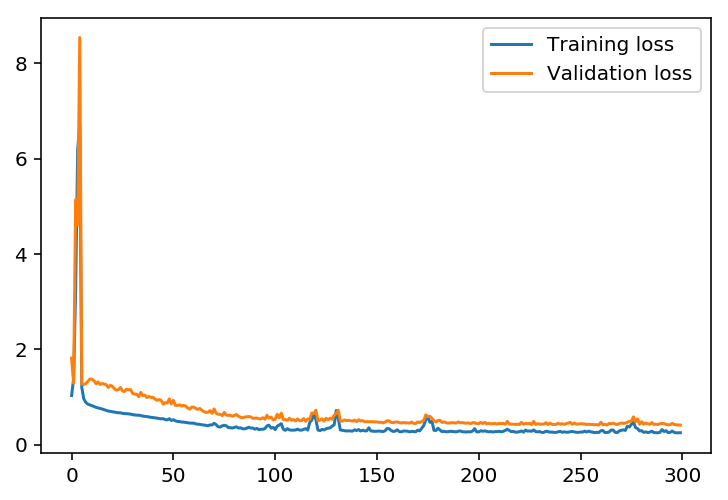

In [139]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

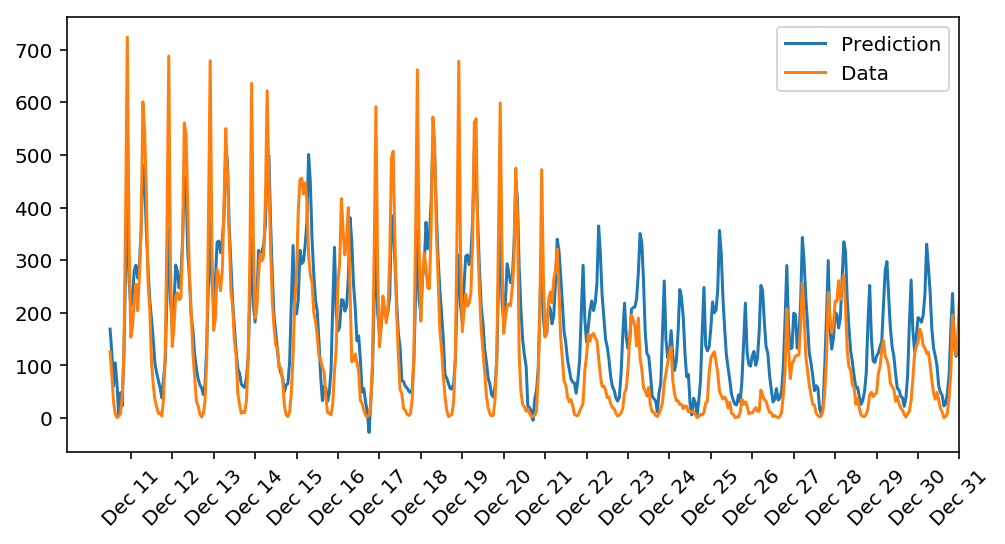

In [140]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below